# Predicting Heart Disease

The WHO estimates that nearly 18 million people die from cardiovascular diseases (CVDs) annually. Being able to identify the risk factors that contribute to CVDs early on could help prevent many premature deaths. In this project, we will use a heart disease dataset from Kaggle uploaded by user Fedesoriano which combines 5 differenet datasets with over 900 observations to build a K-nearest neighbors classifier to try and predict the likelihood of a patient having heart disease in the future.

## 1. Data exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
heart=pd.read_csv("H:\Random files\Data analyst\Dataquest\Data Analyst in Python\Machine Learning in Python\heart.csv")

In [3]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
print(heart.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None 



In [5]:
print("No. features: ", len(heart.columns)-1, "\nNo. observations: ", heart.shape[0])

No. features:  11 
No. observations:  918


In [6]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
heart.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

As we can see, there are a variety of different columns, with a total of 918 observations, 11 features, and 1 target variable (HeartDisease).

We can also see derive some insights from the table of summary statistics:
- The average age of patients is 53.5, so middle-aged.
- There seem to be a couple of large outliers for chloestrol that are pulling the median up compared to the mean.
- Minimum cholestrol level and resting blood pressure of 0 seems to be erroneous results. These may need to be transformed.

We can see that there are no missing values in the dataset, which is good.

Next, we can take a look at some of our categorical columns and see if there are any insights to be derived.

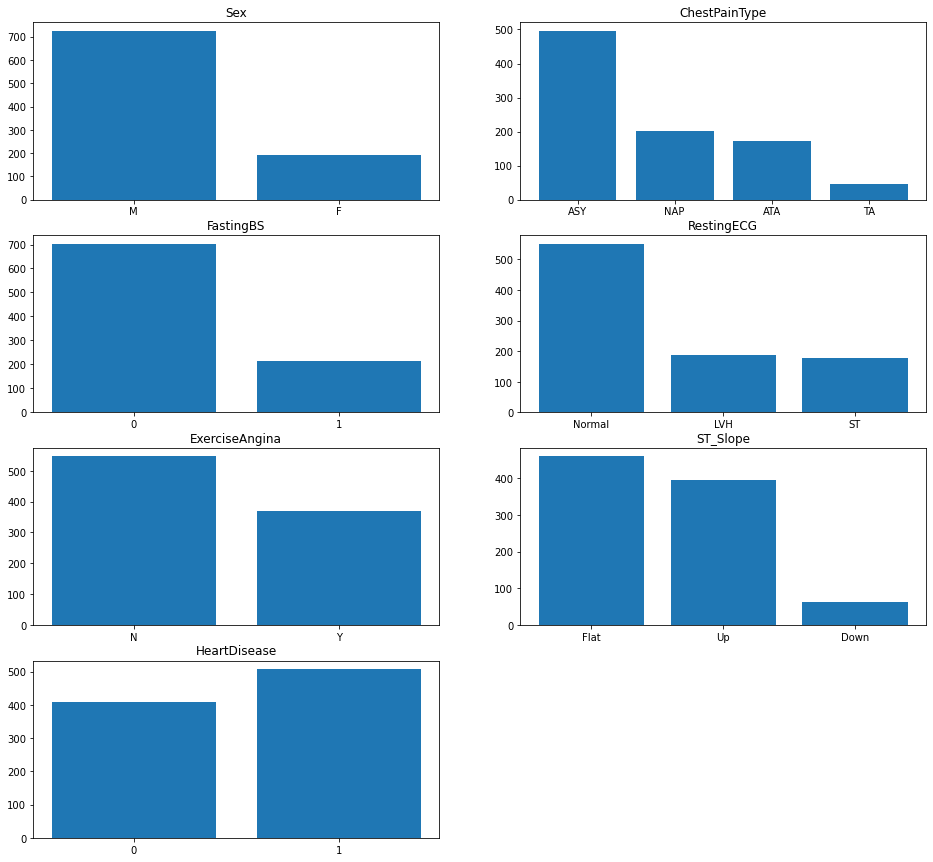

In [8]:
categorical_columns=["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

plt.figure(figsize=(16,15))

for i, cc in enumerate(categorical_columns):
    plt.subplot(4, 2, i+1)
    plt.bar(heart[cc].value_counts().index, heart[cc].value_counts())
    plt.xticks(ticks=np.arange(0,len(heart[cc].value_counts())))
    plt.title(cc)

From the graphs above, we can infer a couple things:
- The dataset is very male-dominated, which could introduce bias to the model.
- A relatively simliar proportion of those with and without heart disease, which helps the model learn from both outcomes.

## 2. Data cleaning

As we identified earlier, there are some values that are 0 that do not make sense, e.g. those in the "Cholestrol" column.

In [9]:
print("No. 0 values in RestingBP column: ", heart["RestingBP"].value_counts().loc[0])
print("No. 0 values in Cholesterol column: ", heart["Cholesterol"].value_counts().loc[0])

No. 0 values in RestingBP column:  1
No. 0 values in Cholesterol column:  172


Since RestingBP only has one zero value, we can just remove that row from consideration. However, for Cholesterol there are many rows with 0 values. We will fill them with the Cholesterol value for the corresponding outcome in HeartDisease.

In [10]:
heart=heart[heart["RestingBP"]!=0]

In [11]:
no_heart_disease_median_cholesterol=heart.loc[(heart["HeartDisease"]==0) & (heart["Cholesterol"]!=0), "Cholesterol"].median()
yes_heart_disease_median_cholesterol=heart.loc[(heart["HeartDisease"]==1) & (heart["Cholesterol"]!=0), "Cholesterol"].median()

heart.loc[(heart["HeartDisease"]==0) & (heart["Cholesterol"]==0), "Cholesterol"]=no_heart_disease_median_cholesterol
heart.loc[(heart["HeartDisease"]==1) & (heart["Cholesterol"]==0), "Cholesterol"]=yes_heart_disease_median_cholesterol

In [12]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,244.573610,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,53.385261,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,246.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## 3. Feature selection

Now that we have cleaned the data, we can start training the model by first selecting the features that will be used in the model. 

We can start by looking at correlations between the features and the target variable. To do this, we first need to convert the categorical columns into dummy variables.

In [13]:
heart=pd.get_dummies(heart, drop_first=True)
heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289.0,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180.0,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283.0,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214.0,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195.0,0,122,0.0,0,1,0,1,0,1,0,0,0,1


Now we can calculate correlations.

<AxesSubplot:>

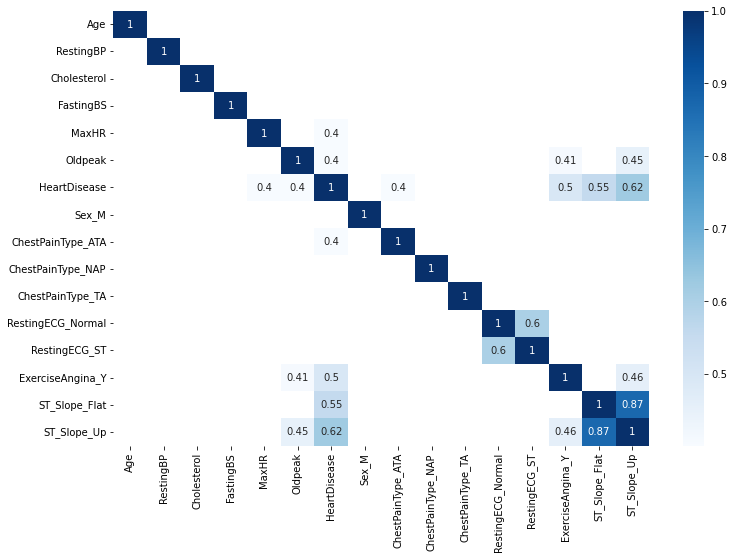

In [14]:
correlation_table=abs(heart.corr()[abs(heart.corr())>0.4])

plt.figure(figsize=(12,8))
sns.heatmap(correlation_table, annot=True, cmap="Blues")

From the correlation heatmap above, we can see that there are some factors that can be considered related in some manner to the target variable:
- MaxHR
- Oldpeak
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

## 4. Building a classifier

Now that we have picked features, we can begin to build the model. First we have to split the data into training and test datasets.

In [15]:
X=heart.drop(["HeartDisease"], axis=1)
y=heart["HeartDisease"]

features=["MaxHR","Oldpeak","ChestPainType_ATA","ExerciseAngina_Y","ST_Slope_Flat","ST_Slope_Up"]

X_train, X_test, y_train, y_test=train_test_split(X[features], y, test_size=0.22, random_state=417)

Next, we need to use grid search to find the optimal permutation of hyperparameters for the kNN model.

In [16]:
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)

grid_params={"n_neighbors": range(1,20), "metric": ["minkowski", "manhattan"]}

knn=KNeighborsClassifier()
knn_grid=GridSearchCV(knn, grid_params, scoring="accuracy")
knn_grid.fit(X_train_scaled, y_train)

print("Best parameters: ", knn_grid.best_params_)
print("Model accuracy on training set: ", knn_grid.best_score_)

Best parameters:  {'metric': 'manhattan', 'n_neighbors': 18}
Model accuracy on training set:  0.8335664335664337


As we can see, our optimal parameters for the kNN model are the Manhattan distance metric and 18 neighbors assessed, which yields an acceptable model accuracy of 83.4%.

Finally, we can evaluate the model on the test dataset.

In [17]:
X_test_scaled=scaler.transform(X_test)
print("Model accuracy on test set: ", knn_grid.best_estimator_.score(X_test_scaled, y_test))

Model accuracy on test set:  0.8267326732673267


We can see that the model accuracy on the test set is 82.7%, very similar to the accuracy of the model for the training set.